In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

torch.manual_seed(2)
np.random.seed(2)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv


In [2]:
''' reading dataset '''
df = pd.read_csv('../input/electric-motor-temperature/pmsm_temperature_data.csv')
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [3]:
''' column names '''
col_names = df.columns.tolist()
p_id = ['profile_id']

t_list = ['pm', 'torque', 'stator_yoke', 'stator_tooth', 'stator_winding']
feature_list = [col for col in col_names if col not in t_list and col not in p_id]

In [4]:
''' checking info of data '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
 12  profile_id      998070 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


In [5]:
''' changing dtype '''
df['profile_id'] = df.profile_id.astype('category')
df.profile_id.unique()

[4, 6, 10, 11, 20, ..., 78, 79, 80, 81, 72]
Length: 52
Categories (52, int64): [4, 6, 10, 11, ..., 79, 80, 81, 72]

In [6]:
''' Data preparation '''

def build_seq(f_df, t_df, seq_length = 10):
    """ Builds sequences from data and converts them into pytorch tensors  """
    data_ = []
    target_ = []
    
    for i in range(int(f_df.shape[0]/seq_length)):
        
        data = torch.from_numpy(f_df.iloc[i: i + seq_length].values.T)
        target = torch.from_numpy(t_df.iloc[i + seq_length + 1].values.T)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    
    return data, target

In [7]:
''' unique values in profiel_id '''
prof_ids = list(df.profile_id.unique())
print(prof_ids)

[4, 6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 72]


In [8]:
prof_id = 6

curr_df = df[df['profile_id'] == prof_id]

''' dropping profile_id '''
curr_df = curr_df.drop('profile_id', axis = 1)
columns = curr_df.columns.tolist()

In [9]:
''' Scaling '''

scaler = MinMaxScaler()
''' fit on data '''
curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)
curr_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,0.422350,0.064550,0.495541,0.173390,0.000066,0.605967,0.957416,0.635014,0.000142,0.000600,0.000105,0.000711
1,0.424296,0.064815,0.495157,0.174028,0.000064,0.610011,0.955582,0.640728,0.000089,0.000826,0.000087,0.000582
2,0.425627,0.064977,0.494894,0.174470,0.000063,0.612710,0.954268,0.644823,0.000089,0.000758,0.000058,0.000427
3,0.426669,0.065209,0.494701,0.174815,0.000062,0.614798,0.953327,0.647756,0.000003,0.000342,0.000021,0.000326
4,0.427242,0.065387,0.494559,0.175044,0.000060,0.616119,0.952652,0.649859,0.000000,0.000086,0.000013,0.000273


In [10]:
seq_l = 5

X = curr_df[feature_list]
y = curr_df[target_list][['pm']]

data, target = build_seq(X, y, sequence_length=seq_l)

In [11]:
''' checking shape of data '''
data.shape

torch.Size([8077, 7, 5])

In [12]:
''' test size '''
test_size = 0.05

idx = torch.randperm(data.shape[0])

train_idx = idx[:int(indices.shape[0] * (1-test_size))]
test_idx = idx[int(indices.shape[0] * (1-test_size)):]

''' X_train, X_test, y_train, y_test '''
X_train, y_train = data[train_idx], target[train_idx]
X_test, y_test = data[test_idx], target[test_idx]

In [13]:
class pms_dataset(torch.utils.data.dataset.Dataset):
    """ Dataset with Rotor Temperature as Target """
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx].float(), self.target[idx].float()

In [14]:
batch_size = 10

train_dataset = pms_dataset(X_train, y_train)
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)

test_dataset = pms_dataset(X_test, y_test)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size= 1)

In [15]:
class Model(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        self.sequence_length = sequence_length
        self.n_features = n_features
        
        ''' Convolutional Layer'''
        self.features = nn.Sequential(nn.Conv1d(n_features, 16, kernel_size=3), nn.ReLU(), nn.Conv1d(16,32, kernel_size=1))
        
        self.lin_in_size = self.get_lin_in_size()
        ''' Linear Model'''
        self.predictior = nn.Sequential(nn.Linear(self.lin_in_size,30), nn.ReLU(), nn.Linear(30, 1))
        
    def forward(self, x):
        
        x = self.features(x)
        x = x.view(-1, self.lin_in_size)
        x = self.predictior(x)
        return x
    
    def get_size(self):
        rand_in = torch.rand(10, self.n_features, self.sequence_length)
        rand_out = self.features(rand_in)
        return rand_out.shape[-1] * rand_out.shape[-2]
        

In [16]:
''' cheking cuda if availabel '''
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_features = X_train.shape[-2]
model = Model(sequence_length, n_features)

''' loading model to cpu or gpu '''
model = model.to(device)

In [17]:
lr = 0.001
loss = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=lr)

In [18]:
''' testing and training '''

def test(net, test_loader, criterion):
    
    net.eval()
    losses = []
    for i, (data, target) in enumerate(test_loader):
        data, target = model.to(device), target.to(device) 
        out = model(data)
        loss = criterion(out, target)
        losses.append(loss.item())  
    
    net.train()
    return np.mean(losses)

''' training function '''
def train(n_epochs, net, train_loader, test_loader, optimizer, criterion, interval = 10):
    net.train()
    train_loss = []
    test_loss = []
    
    for epoch in range(1,n_epochs+1):
        running_loss = 0.0
        batch_losses = []
        
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            batch_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
        
        train_loss.append(np.mean(batch_losses))
        
        test_loss.append(test(net, test_loader, criterion))
        
        if epoch % interval==1:
            print("Epoch {}, Training loss {:.6f}, Testing loss {:.6f}".format(epoch, train_loss[-1], test_loss[-1]))
    return train_loss, test_loss

In [19]:
''' training '''
train_loss, test_loss = train(50, net, train_loader, test_loader, optimizer, criterion)

Epoch 1, Training loss 0.025562, Testing loss 0.015755
Epoch 11, Training loss 0.000588, Testing loss 0.000609
Epoch 21, Training loss 0.000802, Testing loss 0.000440
Epoch 31, Training loss 0.000708, Testing loss 0.000303
Epoch 41, Training loss 0.000613, Testing loss 0.000292


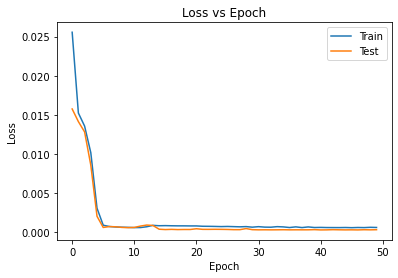

In [20]:
''' train and test loss graph '''
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label ='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
''' testing '''
sc = Model(sequence_length,n_features)
sc.load_state_dict(torch.load('./model_single_measurement.pt'))
sc = sc.to(device)

In [23]:

def get_pred(net, loader):
    
    net.eval()
    t = []
    o = []
    
    for _, (data, target) in enumerate(loader):
        ''' loading data and target on gpu or puc '''
        data, target = data.to(device), target.to(device)
        
        out = net(data)

        t.append(target.item())
        o.append(out.item())
    return t, o

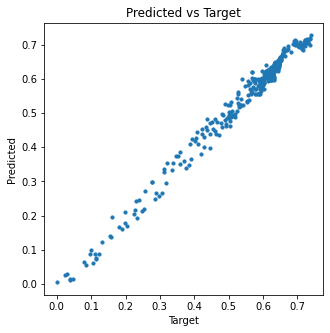

In [24]:
''' plotting predicted and target plot '''
targets, outputs = get_pred(model, test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [25]:
''' R2 score '''
print("R2 Score - ", r2_score(targets, outputs))

R2 Score -  0.9861970550656437
